In [1]:
# Базовые библиотеки: численные массивы + графики
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Разбиение на train/test и метрики качества
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix

# Модель дерева + визуализация структуры и экспорт правил
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text

# “Быстрая интерпретация”: важность признаков через перемешивание (permutation importance)
from sklearn.inspection import permutation_importance

# Фиксируем случайность: так результаты на семинаре будут воспроизводимыми
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [2]:
df=pd.read_csv("S06-hw-dataset-02.csv")
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18000 entries, 0 to 17999
Data columns (total 39 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       18000 non-null  int64  
 1   f01      18000 non-null  float64
 2   f02      18000 non-null  float64
 3   f03      18000 non-null  float64
 4   f04      18000 non-null  float64
 5   f05      18000 non-null  float64
 6   f06      18000 non-null  float64
 7   f07      18000 non-null  float64
 8   f08      18000 non-null  float64
 9   f09      18000 non-null  float64
 10  f10      18000 non-null  float64
 11  f11      18000 non-null  float64
 12  f12      18000 non-null  float64
 13  f13      18000 non-null  float64
 14  f14      18000 non-null  float64
 15  f15      18000 non-null  float64
 16  f16      18000 non-null  float64
 17  f17      18000 non-null  float64
 18  f18      18000 non-null  float64
 19  f19      18000 non-null  float64
 20  f20      18000 non-null  float64
 21  f21      180

In [3]:
df["target"].describe()

count    18000.000000
mean         0.262611
std          0.440065
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          1.000000
Name: target, dtype: float64

In [4]:
df.groupby("target").describe()

id                                                          \
          count         mean          std  min     25%     50%      75%   
target                                                                    
0       13273.0  9002.459128  5196.629931  2.0  4495.0  8993.0  13491.0   
1        4727.0  8994.998942  5195.906874  1.0  4531.5  9017.0  13521.5   

                     f01            ...   x_int_1             x_int_2  \
            max    count      mean  ...       75%        max    count   
target                              ...                                 
0       17999.0  13273.0 -0.302006  ...  4.784096  94.891804  13273.0   
1       18000.0   4727.0 -0.745815  ...  2.959533  47.136942   4727.0   

                                                                           \
             mean        std           min       25%       50%        75%   
target                                                                      
0       29.432474  59.744859  1.895059e-07  1.464103  7.873393  30.552057   
1       15.456442  32.177175  5.403132e-07  0.777923  4.178957  16.173690   

                     
                max  
target               
0       1103.449067  
1        518.570409  

[2 rows x 304 columns]

In [5]:
X=df.drop(["id","target"],axis=1)
X

,f01,f02,f03,f04,f05,f06,f07,f08,f09,f10,...,f28,f29,f30,f31,f32,f33,f34,f35,x_int_1,x_int_2
0,-0.149235,-2.826966,-0.522901,-4.198449,1.364943,0.815043,-1.195518,-1.932232,2.396353,1.121683,...,0.293322,-0.159323,0.448015,0.572745,0.149916,0.878392,-0.679733,1.412751,0.421883,9.217167
1,-1.966180,-4.877542,0.268367,-9.607791,0.097149,1.347185,-3.872575,-0.395117,1.710068,-0.298809,...,1.924549,-0.389212,1.383794,0.169876,0.043969,-0.963545,1.006643,-2.488690,9.590124,24.772826
2,-0.555964,-0.999920,0.209673,-14.119498,-1.808950,-0.006222,-4.651108,0.911944,-0.289037,-0.092692,...,0.792870,-1.383970,3.044321,-0.182864,1.425649,-8.418598,-4.629754,-0.439798,0.555919,41.800517
3,-2.049199,-5.600713,-1.664677,-6.263893,-5.224455,0.848351,1.407210,-0.542080,0.119102,0.681733,...,-0.732601,-2.713080,2.762637,-0.520796,-0.142455,1.668338,2.292810,-10.744916,11.476977,65.315860
4,-0.220556,4.889479,-2.235840,6.450046,0.774389,-2.382625,2.584816,4.211856,-0.317889,-1.275888,...,1.948262,-1.302872,2.478862,1.528610,1.098131,3.547087,2.517757,-9.364106,-1.078404,93.017870
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17995,-1.920557,-1.422719,-1.031828,2.094948,-0.067437,-0.469716,1.427896,1.429689,-1.938858,0.172874,...,1.072118,-0.768946,-2.549755,2.079189,0.206839,4.900957,1.888136,-2.584146,2.732414,4.528493
17996,-1.914101,-2.124938,1.216011,-9.308270,-1.024236,-0.301606,-5.320400,-1.922336,1.645415,-0.427257,...,-0.234799,0.821849,0.794824,-0.043603,0.622274,-5.862803,-0.918845,-1.203823,4.067347,105.359894
17997,-1.846604,7.583639,-1.107318,3.319625,3.065063,0.791241,-2.855133,0.717440,1.554351,0.557274,...,0.171230,0.458406,-3.135470,0.651596,-1.625199,-2.758888,1.770906,-0.067665,-14.003977,12.202548
17998,1.742157,1.722399,-0.849028,5.751745,3.271935,-1.666774,4.501935,1.714487,0.528713,-1.065804,...,-1.058330,-1.607060,0.248146,-0.448578,0.681331,7.190156,-1.025952,3.629549,3.000691,28.088015


In [6]:
y=df["target"]
y

0        1
1        0
2        0
3        0
4        0
        ..
17995    1
17996    0
17997    0
17998    0
17999    1
Name: target, Length: 18000, dtype: int64

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=RANDOM_STATE, stratify=y
)
# seed важен для возможности обучить точно такуюже модель после нового запуска программы, stratify нужен для сохранения распределения классов таргета

In [8]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    f1_score,
    roc_auc_score
)
DummyBaseline = DummyClassifier(strategy="most_frequent", random_state=RANDOM_STATE)
DummyBaseline.fit(X_train, y_train)
y_test_pred_baseline = DummyBaseline.predict(X_test)
y_test_proba_baseline = DummyBaseline.predict_proba(X_test)[:, 1]
print("=== Бейзлайн (DummyClassifier, most_frequent) – качество на test ===")
print("Accuracy :", accuracy_score(y_test, y_test_pred_baseline))
print("Precision:", precision_score(y_test, y_test_pred_baseline, zero_division=0))
print("F1-score :", f1_score(y_test, y_test_pred_baseline, zero_division=0))
print("ROC-AUC  :", roc_auc_score(y_test, y_test_proba_baseline))

=== Бейзлайн (DummyClassifier, most_frequent) – качество на test ===
Accuracy : 0.7373333333333333
Precision: 0.0
F1-score : 0.0
ROC-AUC  : 0.5


In [9]:
pipe = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(max_iter=1000,C=1.0,random_state=RANDOM_STATE))
])
pipe.fit(X_train, y_train)
y_test_pred = pipe.predict(X_test)
y_test_proba = pipe.predict_proba(X_test)[:, 1]
print("=== Логистическая регрессия – качество на test ===")
print("Accuracy :", accuracy_score(y_test, y_test_pred))
print("Precision:", precision_score(y_test, y_test_pred, zero_division=0))
print("F1-score :", f1_score(y_test, y_test_pred, zero_division=0))
print("ROC-AUC  :", roc_auc_score(y_test, y_test_proba))

=== Логистическая регрессия – качество на test ===
Accuracy : 0.8162222222222222
Precision: 0.7369826435246996
F1-score : 0.5717244950802693
ROC-AUC  : 0.8008904412072182


In [10]:
def print_metrics(y_true, y_pred, y_proba=None, title=None):
    # y_true, y_pred: истинные и предсказанные метки классов (например, 0/1)
    # y_proba: вероятность класса 1 (нужна, если хотим посчитать ROC-AUC)
    if title:
        print(title)
    # Accuracy – доля правильных ответов (хороша как “первая” метрика, но не всегда достаточно)
    acc = accuracy_score(y_true, y_pred)
    # F1 – баланс precision/recall (часто полезнее accuracy при дисбалансе классов)
    f1 = f1_score(y_true, y_pred)
    precision=precision_score(y_test, y_test_pred, zero_division=0)
    print(f"accuracy = {acc:.4f}")
    print(f"f1       = {f1:.4f}")
    print(f"precision = {precision:.4f}")
    if y_proba is not None:
        # ROC-AUC корректно считать по вероятностям/скорингам, а не по “жёстким” классам
        try:
            auc = roc_auc_score(y_true, y_proba)
            print(f"roc_auc  = {auc:.4f}")
        except Exception:
            # Иногда AUC может не считаться (например, если в y_true один класс)
            pass
    print("confusion_matrix:")
    print(confusion_matrix(y_true, y_pred))
    print()

In [11]:
tree_full = DecisionTreeClassifier(max_depth=10, min_samples_leaf=10, random_state=RANDOM_STATE)
tree_full.fit(X_train, y_train)

# Сравним качество на train и test – это базовый способ “поймать” переобучение.
y_pred_train = tree_full.predict(X_train)
y_pred_test = tree_full.predict(X_test)

print_metrics(y_train, y_pred_train, title="FULL TREE – train")
print_metrics(y_test, y_pred_test, title="FULL TREE – test")

FULL TREE – train
accuracy = 0.8878
f1       = 0.7649
precision = 0.7370
confusion_matrix:
[[9521  434]
 [1081 2464]]

FULL TREE – test
accuracy = 0.8331
f1       = 0.6453
precision = 0.7370
confusion_matrix:
[[3066  252]
 [ 499  683]]



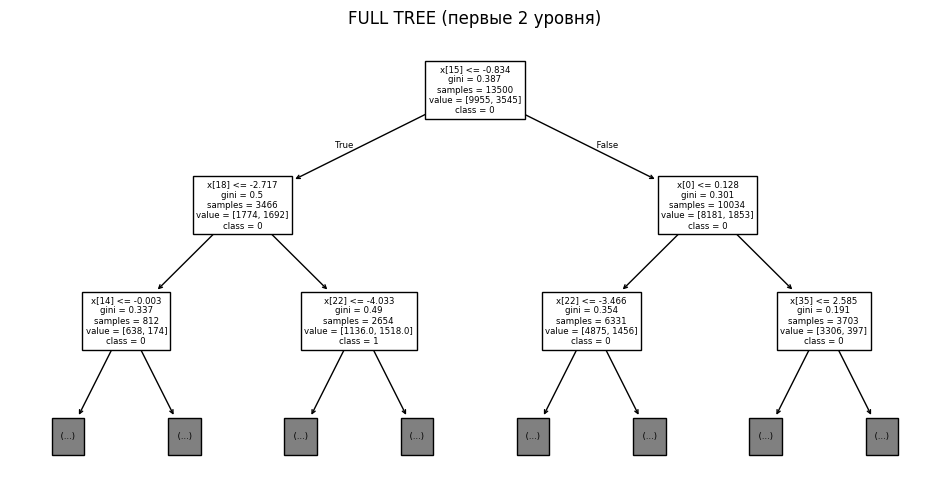

In [12]:
plt.figure(figsize=(12, 6))
plot_tree(tree_full, max_depth=2, filled=False, class_names=["0", "1"])
plt.title("FULL TREE (первые 2 уровня)")
plt.show()

In [13]:
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.inspection import permutation_importance
rf = RandomForestClassifier(
    n_estimators=400,
    random_state=RANDOM_STATE,
    max_depth=10,
    oob_score=True,
    n_jobs=-1,
    # max_features="sqrt"  # по умолчанию для классификации обычно sqrt(n_features)
)
rf.fit(X_train, y_train)

print(f"RandomForest oob_score_ = {rf.oob_score_:.4f}")
print_metrics(y_test, rf.predict(X_test), title="RandomForest – test")

RandomForest oob_score_ = 0.8673
RandomForest – test
accuracy = 0.8691
f1       = 0.6879
precision = 0.7370
confusion_matrix:
[[3262   56]
 [ 533  649]]



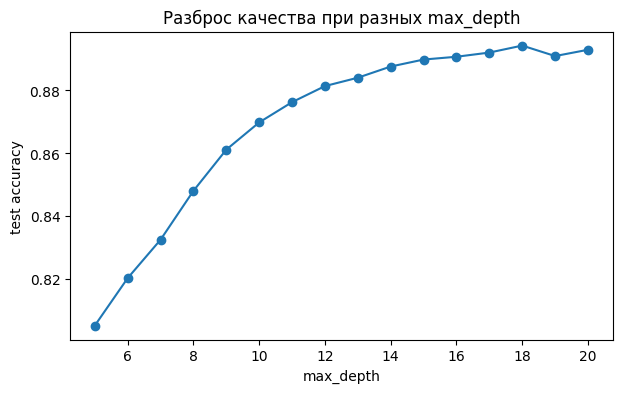

In [16]:
acc_rf=[]
seed=np.arange(5,21)
for s in seed:
    r = RandomForestClassifier(n_estimators=300, random_state=RANDOM_STATE, max_depth=s, n_jobs=-1)
    r.fit(X_train, y_train)
    acc_rf.append(accuracy_score(y_test, r.predict(X_test)))
plt.figure(figsize=(7, 4))
plt.plot(seed, acc_rf, marker="o", label="RandomForest")
plt.xlabel("max_depth")
plt.ylabel("test accuracy")
plt.title("Разброс качества при разных max_depth")
plt.savefig("./artifacts/figures/max_deth.png")

In [17]:
from sklearn.ensemble import GradientBoostingClassifier
def eval_binary(model, X_train, y_train, X_test, y_test, title=None):
    # Мини-обёртка: обучить модель на train и оценить на test.
    # Возвращаем обученную модель – её удобно дальше использовать (например, рисовать границу).
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    proba = None
    if hasattr(model, "predict_proba"):
        # Для ROC-AUC нужна "уверенность" модели: вероятность положительного класса
        proba = model.predict_proba(X_test)[:, 1]
    print_metrics(y_test, pred, y_proba=proba, title=title)
    return model
gb = GradientBoostingClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=2,
    random_state=RANDOM_STATE
)

gb = eval_binary(gb, X_train, y_train, X_test, y_test, title="GradientBoosting – test")

GradientBoosting – test
accuracy = 0.8529
f1       = 0.6573
precision = 0.7370
roc_auc  = 0.8780
confusion_matrix:
[[3203  115]
 [ 547  635]]



Наибольшей точностью обладает RandomForestClassifier

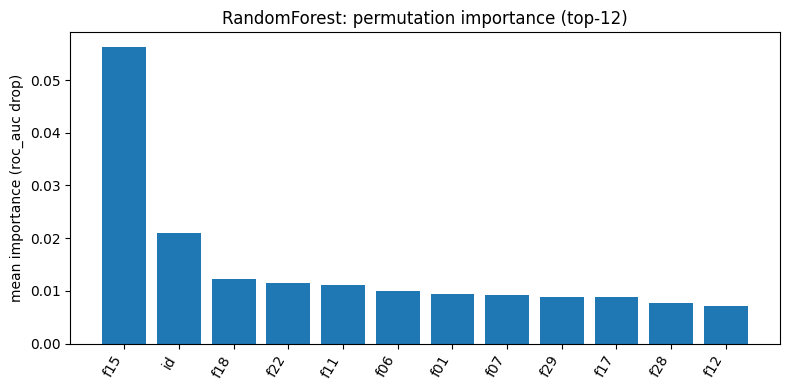

In [18]:
perm = permutation_importance(
    rf, X_test, y_test,
    n_repeats=8,
    random_state=RANDOM_STATE,
    scoring="roc_auc"
)
feature_names = df.columns
pimp = perm.importances_mean
idx = np.argsort(pimp)[::-1][:12]

plt.figure(figsize=(8, 4))
plt.bar(range(len(idx)), pimp[idx])
plt.xticks(range(len(idx)), [feature_names[i] for i in idx], rotation=60, ha="right")
plt.ylabel("mean importance (roc_auc drop)")
plt.title("RandomForest: permutation importance (top-12)")
plt.tight_layout()
plt.savefig("./artifacts/figures/permutation_importance.png")


Всего один признак имеет значительно большую важность чем остальные